<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap09/9_5_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 9.5: Augmentation**

This notebook investigates data augmentation for the MNIST-1D model.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


<div style="color:green">
The !git clone command worked to clone it into the folder where the notebook is, but couldn't run it afterwards, saying that the project didn't have attribute .data. Solved it by instead pip installing the project. Not sure what the issue is, but maybe something to do with dependency issues.
</div>

In [31]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d.git

  Cloning https://github.com/greydanus/mnist1d.git to c:\users\harry\appdata\local\temp\pip-req-build-2ddt8c56
  Resolved https://github.com/greydanus/mnist1d.git to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git 'C:\Users\harry\AppData\Local\Temp\pip-req-build-2ddt8c56'


In [37]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d.data
import random

In [39]:
import os

# Set up data path
data_path = os.path.join('.', 'mnist1d_data.pkl')

# Get dataset arguments and load data
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path=data_path, download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from .\mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [33]:
D_i = 40    # Input dimensions
D_k = 200   # Hidden dimensions
D_o = 10    # Output dimensions

# Define a model with two hidden layers of size 100
# And ReLU activations between them
model = nn.Sequential(
nn.Linear(D_i, D_k),
nn.ReLU(),
nn.Linear(D_k, D_k),
nn.ReLU(),
nn.Linear(D_k, D_o))

def weights_init(layer_in):
  # Initialize the parameters with He initialization
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Call the function you just defined
model.apply(weights_init)

Sequential(
  (0): Linear(in_features=40, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=10, bias=True)
)

In [35]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
errors_train = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  print(f'Epoch {epoch:5d}, train error {errors_train[epoch]:3.2f}, test error {errors_test[epoch]:3.2f}')

Epoch     0, train error 55.15, test error 65.80
Epoch     1, train error 43.85, test error 55.70
Epoch     2, train error 33.68, test error 48.10
Epoch     3, train error 26.35, test error 43.40
Epoch     4, train error 21.78, test error 45.20
Epoch     5, train error 15.80, test error 41.20
Epoch     6, train error 14.75, test error 41.70
Epoch     7, train error 11.20, test error 38.20
Epoch     8, train error 7.90, test error 38.60
Epoch     9, train error 6.22, test error 40.80
Epoch    10, train error 4.62, test error 38.40
Epoch    11, train error 1.95, test error 36.10
Epoch    12, train error 1.60, test error 37.50
Epoch    13, train error 1.28, test error 36.20
Epoch    14, train error 0.47, test error 36.40
Epoch    15, train error 0.07, test error 36.70
Epoch    16, train error 0.00, test error 36.60
Epoch    17, train error 0.00, test error 36.90
Epoch    18, train error 0.00, test error 36.70
Epoch    19, train error 0.00, test error 36.40
Epoch    20, train error 0.00, t

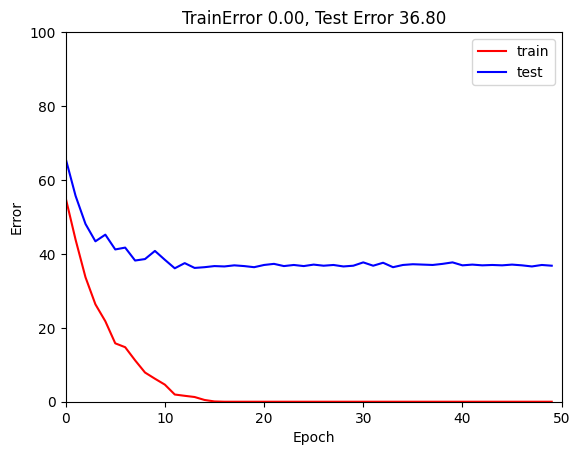

In [36]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

The best test performance is about 33%.  Let's see if we can improve on that by augmenting the data.

In [52]:
def augment(input_vector):
  # Create output vector
  data_out = np.zeros_like(input_vector)
  

  # TODO:  Shift the input data by a random offset
  # (rotating, so points that would go off the end, are added back to the beginning)
  # Replace this line:
  data_out = np.roll(input_vector, np.random.randint(data_out.shape[0]))

  # TODO:    # Randomly scale the data by a factor drawn from a uniform distribution over [0.8,1.2]
  # Replace this line:
  scale_factor = np.random.uniform(0.8, 1.2)
  data_out = data_out * scale_factor

  return data_out

In [53]:
n_data_orig = data['x'].shape[0]
# We'll double the amount o fdata
n_data_augment = n_data_orig+4000
augmented_x = np.zeros((n_data_augment, D_i))
augmented_y = np.zeros(n_data_augment)
# First n_data_orig rows are original data
augmented_x[0:n_data_orig,:] = data['x']
augmented_y[0:n_data_orig] = data['y']

# Fill in rest of with augmented data
for c_augment in range(n_data_orig, n_data_augment):
  # Choose a data point randomly
  random_data_index = random.randint(0, n_data_orig-1)
  # Augment the point and store
  augmented_x[c_augment,:] = augment(data['x'][random_data_index,:])
  augmented_y[c_augment] = data['y'][random_data_index]


In [55]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 50 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(augmented_x.astype('float32'))
y_train = torch.tensor(augmented_y.transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
errors_train_aug = np.zeros((n_epoch))
errors_test_aug = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train_aug[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test_aug[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  print(f'Epoch {epoch:5d}, train error {errors_train_aug[epoch]:3.2f}, test error {errors_test_aug[epoch]:3.2f}')

Epoch     0, train error 58.74, test error 61.80
Epoch     1, train error 42.21, test error 51.00
Epoch     2, train error 35.59, test error 45.30
Epoch     3, train error 30.36, test error 41.30
Epoch     4, train error 27.03, test error 42.30
Epoch     5, train error 23.31, test error 42.20
Epoch     6, train error 19.09, test error 38.30
Epoch     7, train error 17.46, test error 38.00
Epoch     8, train error 15.84, test error 38.00
Epoch     9, train error 11.78, test error 37.30
Epoch    10, train error 9.35, test error 35.90
Epoch    11, train error 8.99, test error 38.30
Epoch    12, train error 7.28, test error 35.80
Epoch    13, train error 4.56, test error 35.00
Epoch    14, train error 4.45, test error 34.10
Epoch    15, train error 3.94, test error 34.60
Epoch    16, train error 2.88, test error 36.80
Epoch    17, train error 2.38, test error 36.20
Epoch    18, train error 1.49, test error 35.60
Epoch    19, train error 0.22, test error 34.90
Epoch    20, train error 0.01,

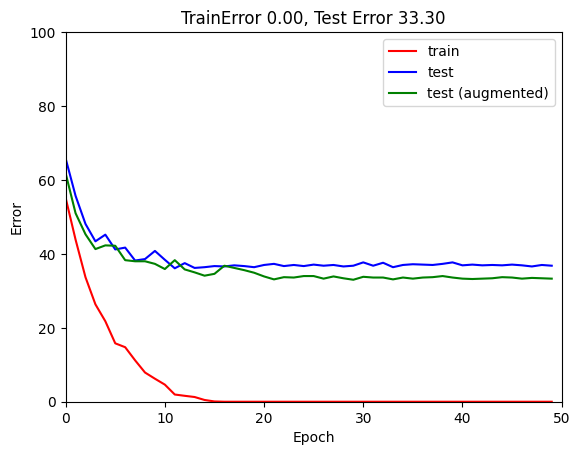

In [56]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.plot(errors_test_aug,'g-',label='test (augmented)')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train_aug[-1],errors_test_aug[-1]))
ax.legend()
plt.show()

Hopefully, you should see an improvement in performance when we augment the data.